In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import DataSplitter
import utils
from sklearn.preprocessing import StandardScaler
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Recursive with feature importance

Docs https://skforecast.org/0.11.0/user_guides/autoregresive-forecaster.html

Example https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

SHAP https://skforecast.org/0.11.0/user_guides/explainability.html

In [3]:
df60 = DataSplitter.getTrainData(60)
df60_line = df60[df60['line'] == '1A']
df60_line = df60_line.reset_index(drop=True)

train60, val60 = DataSplitter.performTrainValSplit(df60_line)
train60_line = train60.reset_index(drop=True)
val60_line = val60.reset_index(drop=True)

target = 'passengersBoarding'
dropCols = ['date', 'hour', 'year', 'quarter', 'Q1', 'month', 'monthNumber', 'weekNumber', 'weekDay', 
            'dateNumber', 'mon', 'workdayPlan', 'line', 'passengersBoarding', 'eventName', 'diff', 'datetime',
            'diffLag1', 'diffLag2', 'diffLag3', 'diffLag4', 'diffLag5', 'diffLag6', 'diffLag7', 'diffLag8', 'diffLag9', 'diffLag10',
            'diffLag11', 'diffLag12', 'diffLag13', 'diffLag14', 'diffLag15', 'diffLag16', 'diffLag17', 'diffLag18', 'diffLag19', 'diffLag20',
            'diffLag40', 'diffLag60', 'diffLag80', 'diffLag100', 'diffLag120', 'diffLag140']

train_index = pd.RangeIndex(start=0, stop=train60_line.shape[0])
val_index = pd.RangeIndex(start=train60_line.shape[0], stop=train60_line.shape[0]+val60_line.shape[0])

X_train = train60_line.drop(columns=dropCols, axis=1)
y_train = train60_line[target]
X_val = val60_line.drop(columns=dropCols, axis=1)
y_val = val60_line[target]

X_train.index = train_index
y_train.index = train_index
X_val.index = val_index
y_val.index = val_index

In [67]:
model = xgb.XGBRegressor(n_estimators=100, max_depth=10, eta=0.15, seed=42)

scalar = StandardScaler()
exog_scalar = StandardScaler()
forecaster = ForecasterAutoreg(
                 regressor = model,
                 lags      = [1, 4, 8, 20, 40, 120, 140],
                 differentiation=1,
                 transformer_y=scalar,
                 transformer_exog=exog_scalar
             )

forecaster.fit(y=y_train, exog=X_train)
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.15, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...) 
Lags: [  1   4   8  20  40 120 140] 
Transformer for y: StandardScaler() 
Transformer for exog: StandardScaler() 
Window size: 141 
Weight function included: False 
Differentiation order: 1 
Exogenous included: True 
Type of exogenous

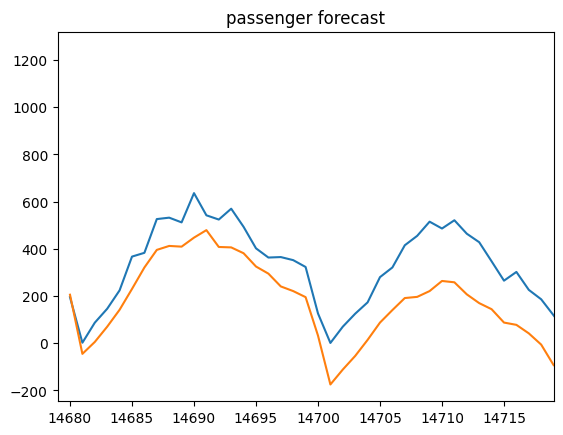

In [68]:
y_train_pred = forecaster.predict(steps=40, exog=X_val[:40])
y_train_pred
plt.plot(X_val.index, val60_line['passengersBoarding'])
plt.plot(X_val.index[:40], y_train_pred)
plt.xlim([14679, 14679+40])
plt.title('passenger forecast')
plt.show()

training MAE%: 0.048
training MAPE: 0.119
training RMSE%: 0.066


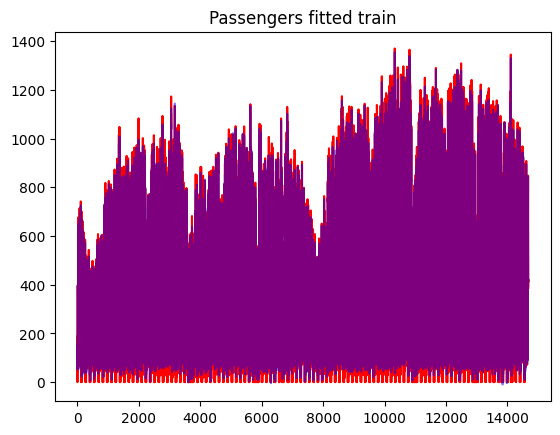

In [69]:
X_train['lag_1'] = y_train.shift(periods=1).fillna(0)
#X_train['lag_20'] = y_train.shift(periods=20).fillna(0)
#X_train['lag_120'] = y_train.shift(periods=120).fillna(0)
#X_train['lag_140'] = y_train.shift(periods=140).fillna(0)

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

print('training MAE%:', utils.MAE(y=y_train, yhat=y_train_pred))
print('training MAPE:', utils.MAPE(y=y_train, yhat=y_train_pred))
print('training RMSE%:', utils.RMSE(y=y_train, yhat=y_train_pred))

plt.plot(X_train.index, y_train, color='red')
plt.plot(X_train.index, y_train_pred, color='blue', alpha=0.5)
plt.title('Passengers fitted train')
plt.show()

In [70]:
explainer = shap.Explainer(model.predict, X_train)
shap_values = explainer(X_train)

PermutationExplainer explainer: 14681it [06:43, 35.48it/s]                           


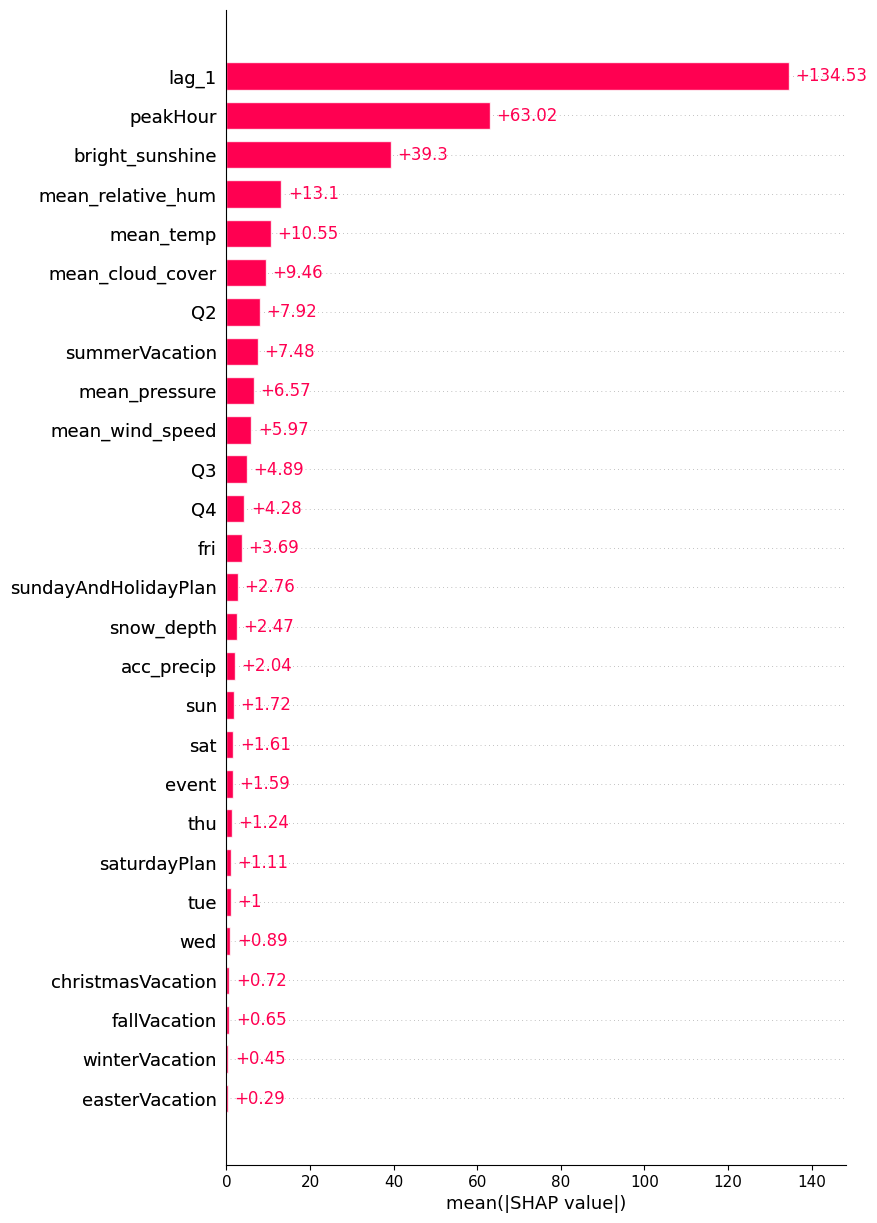

In [71]:
shap.plots.bar(shap_values, max_display=52)

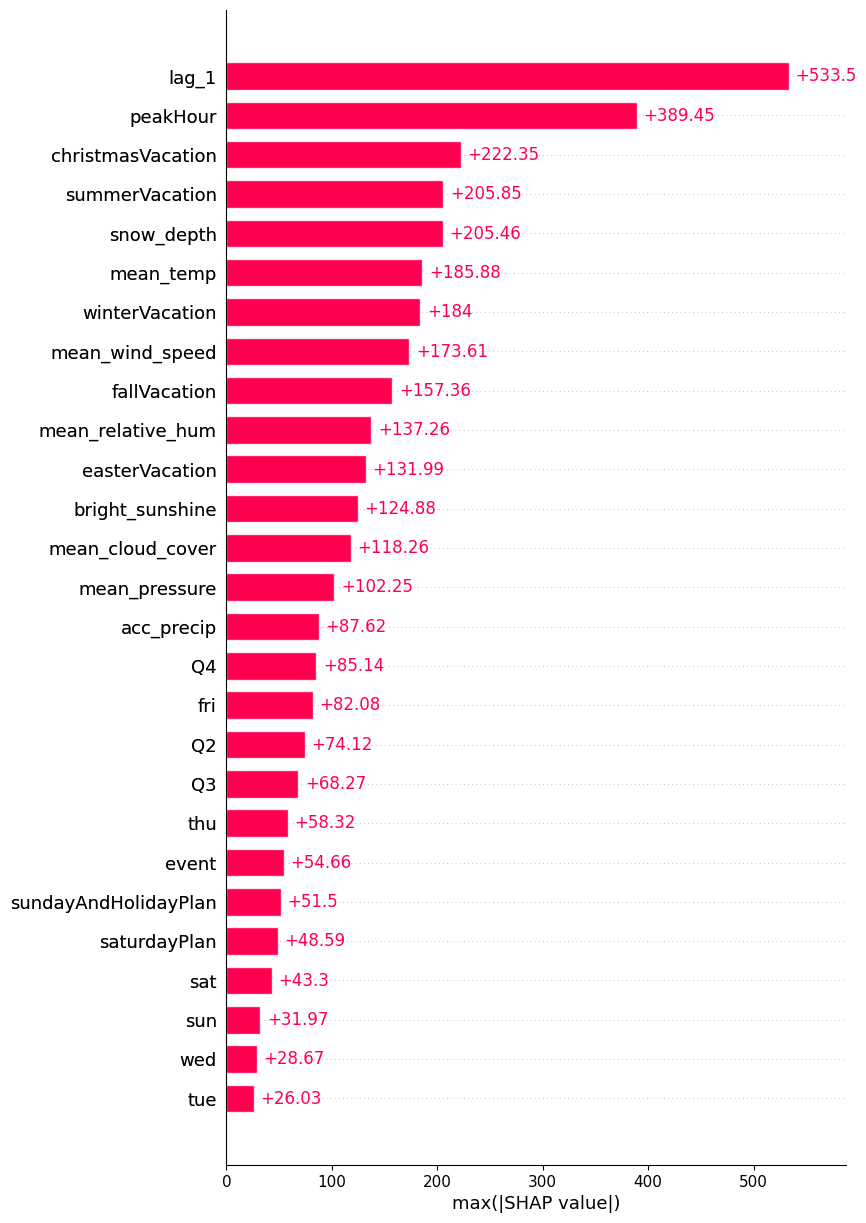

In [72]:
shap.plots.bar(shap_values.abs.max(0), max_display=52)

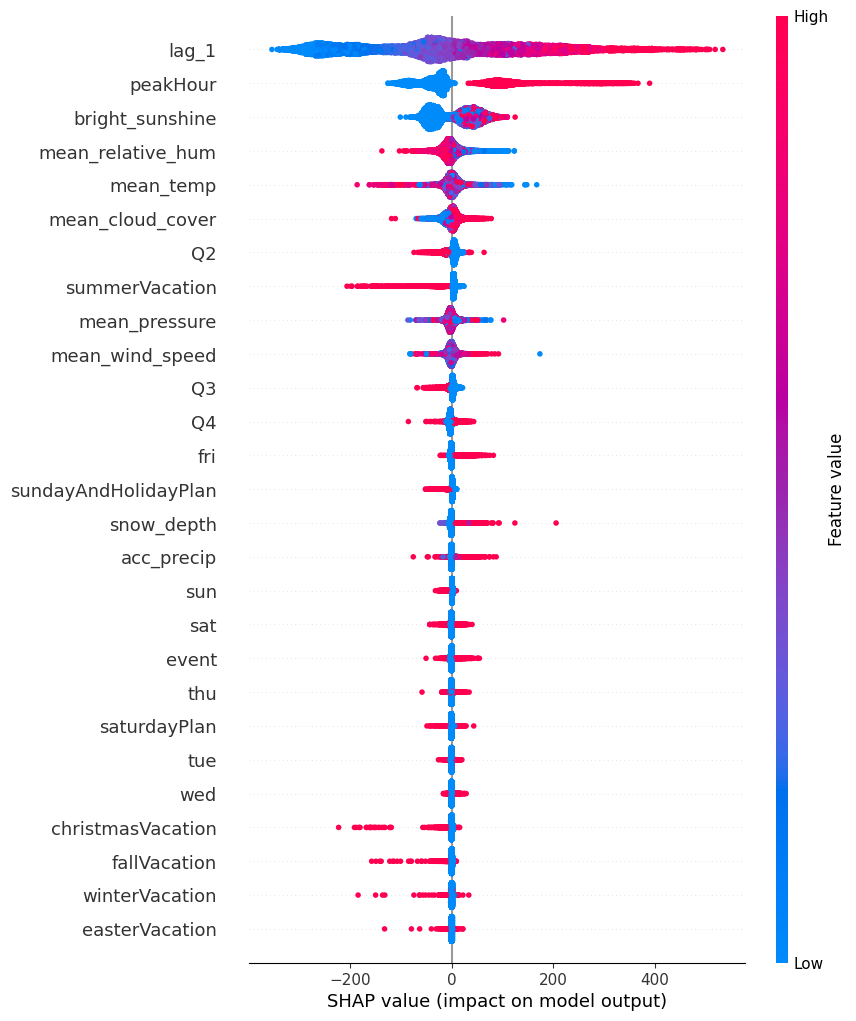

In [73]:
shap.plots.beeswarm(shap_values, max_display=52)

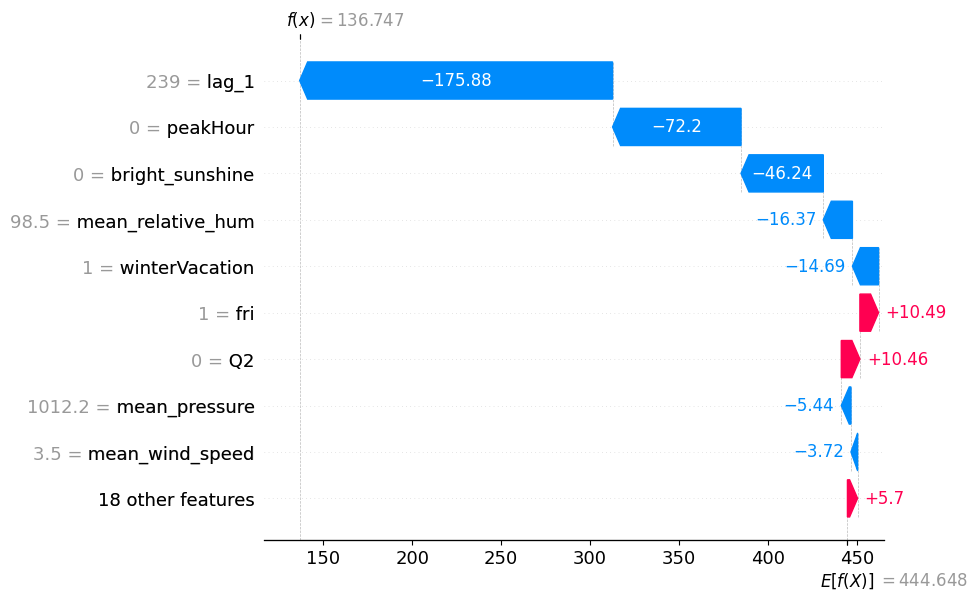

In [84]:
shap.plots.waterfall(shap_values[12000])

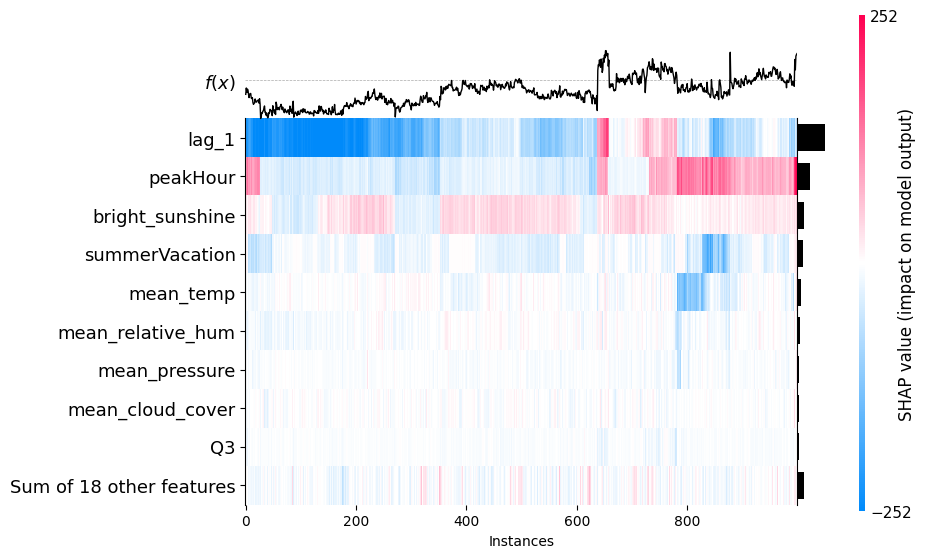

In [74]:
shap.plots.heatmap(shap_values[:1000])

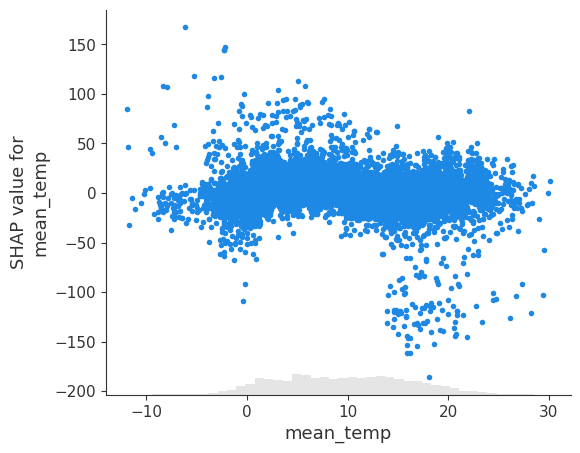

In [75]:
shap.plots.scatter(shap_values[:, 'mean_temp'])

In [86]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_train, y_train, n_repeats=30, random_state=42)

# Recursive forecasting

In [3]:
df60 = DataSplitter.getTrainData(60)
df60_line = df60[df60['line'] == '1A']
df60_line = df60_line.reset_index(drop=True)

train60, val60 = DataSplitter.performTrainValSplit(df60_line)
train60_line = train60.reset_index(drop=True)
val60_line = val60.reset_index(drop=True)

target = 'passengersBoarding'
dropCols = ['date', 'hour', 'year', 'quarter', 'Q1', 'month', 'monthNumber', 'weekNumber', 'weekDay', 
            'dateNumber', 'mon', 'workdayPlan', 'line', 'passengersBoarding', 'eventName', 'diff', 'datetime',
            'diffLag1', 'diffLag2', 'diffLag3', 'diffLag4', 'diffLag5', 'diffLag6', 'diffLag7', 'diffLag8', 'diffLag9', 'diffLag10',
            'diffLag11', 'diffLag12', 'diffLag13', 'diffLag14', 'diffLag15', 'diffLag16', 'diffLag17', 'diffLag18', 'diffLag19', 'diffLag20',
            'diffLag40', 'diffLag60', 'diffLag80', 'diffLag100', 'diffLag120', 'diffLag140']

train_index = pd.RangeIndex(start=0, stop=train60_line.shape[0])
val_index = pd.RangeIndex(start=train60_line.shape[0], stop=train60_line.shape[0]+val60_line.shape[0])

X_train = train60_line.drop(columns=dropCols, axis=1)
y_train = train60_line[target]
X_val = val60_line.drop(columns=dropCols, axis=1)
y_val = val60_line[target]

X_train.index = train_index
y_train.index = train_index
X_val.index = val_index
y_val.index = val_index

import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
#elif torch.backends.mps.is_available():
#    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

cpu


The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.


Execution time: 0.184 sec
train MAE%: 0.151
train MAPE: 0.374
train RMSE%: 0.199
val MAE%: 0.316
val MAPE: 0.631
val RMSE%: 0.416


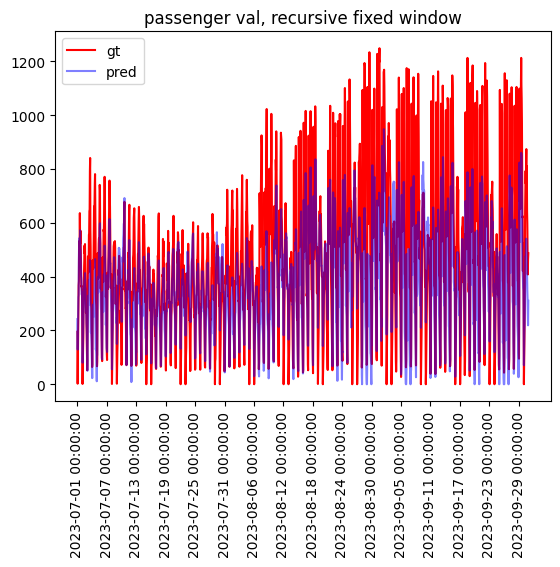

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

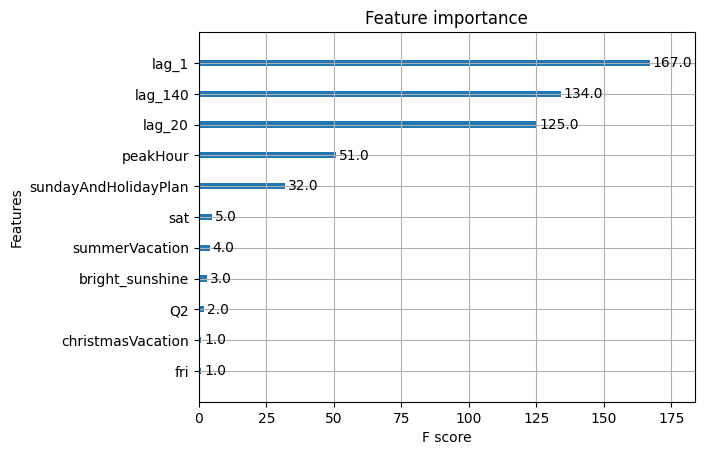

In [8]:
# fixed window forecast (reestimation)
horizon = 40
lags = [1, 20, 140]
diff = 1

model = xgb.XGBRegressor(n_estimators=35, max_depth=4, eta=0.05, seed=42)
scalar = StandardScaler()
exog_scalar = StandardScaler()

model, y_train_pred, y_val_pred = utils.fixedWindowForecastSklearn(
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model,
    horizon=horizon, differentiation=diff, lags=lags, 
    scalar=scalar, exog_scalar=exog_scalar)

print('train MAE%:', utils.MAE(y=y_train, yhat=y_train_pred))
print('train MAPE:', utils.MAPE(y=y_train, yhat=y_train_pred))
print('train RMSE%:', utils.RMSE(y=y_train, yhat=y_train_pred))

print('val MAE%:', utils.MAE(y=y_val, yhat=y_val_pred))
print('val MAPE:', utils.MAPE(y=y_val, yhat=y_val_pred))
print('val RMSE%:', utils.RMSE(y=y_val, yhat=y_val_pred))

plt.plot(X_val.index, val60_line['passengersBoarding'], color='red', label='gt')
plt.plot(X_val.index, y_val_pred, color='blue', alpha=0.5, label='pred')
plt.xticks(range(y_val.index[0], y_val.index[-1] + 1, horizon*3), val60_line['datetime'].values[::horizon*3], rotation=90)
plt.title('passenger val, recursive fixed window')
plt.legend()
plt.show()

xgb.plot_importance(model)

RangeIndex(start=0, stop=14680, step=1)
RangeIndex(start=0, stop=14720, step=1)
RangeIndex(start=0, stop=14760, step=1)
RangeIndex(start=0, stop=14800, step=1)
RangeIndex(start=0, stop=14840, step=1)
RangeIndex(start=0, stop=14880, step=1)


The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.


RangeIndex(start=0, stop=14920, step=1)
RangeIndex(start=0, stop=14960, step=1)
RangeIndex(start=0, stop=15000, step=1)
RangeIndex(start=0, stop=15040, step=1)
RangeIndex(start=0, stop=15080, step=1)
RangeIndex(start=0, stop=15120, step=1)
RangeIndex(start=0, stop=15160, step=1)
RangeIndex(start=0, stop=15200, step=1)
RangeIndex(start=0, stop=15240, step=1)
RangeIndex(start=0, stop=15280, step=1)
RangeIndex(start=0, stop=15320, step=1)
RangeIndex(start=0, stop=15360, step=1)
RangeIndex(start=0, stop=15400, step=1)
RangeIndex(start=0, stop=15440, step=1)
RangeIndex(start=0, stop=15480, step=1)
RangeIndex(start=0, stop=15520, step=1)
RangeIndex(start=0, stop=15560, step=1)
RangeIndex(start=0, stop=15600, step=1)
RangeIndex(start=0, stop=15640, step=1)
RangeIndex(start=0, stop=15680, step=1)
RangeIndex(start=0, stop=15720, step=1)
RangeIndex(start=0, stop=15760, step=1)
RangeIndex(start=0, stop=15800, step=1)
RangeIndex(start=0, stop=15840, step=1)
RangeIndex(start=0, stop=15880, step=1)


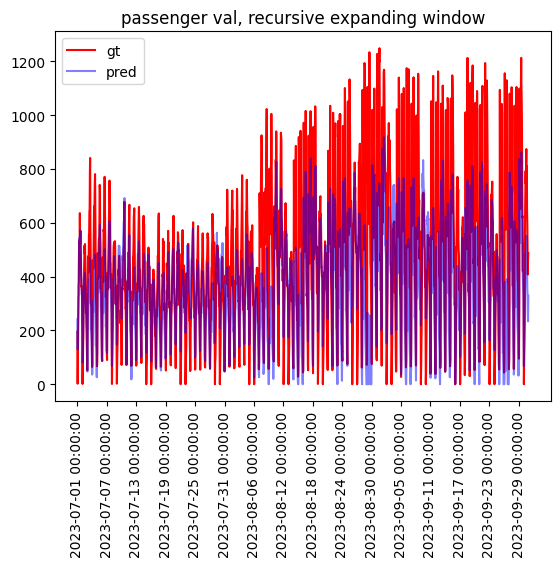

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

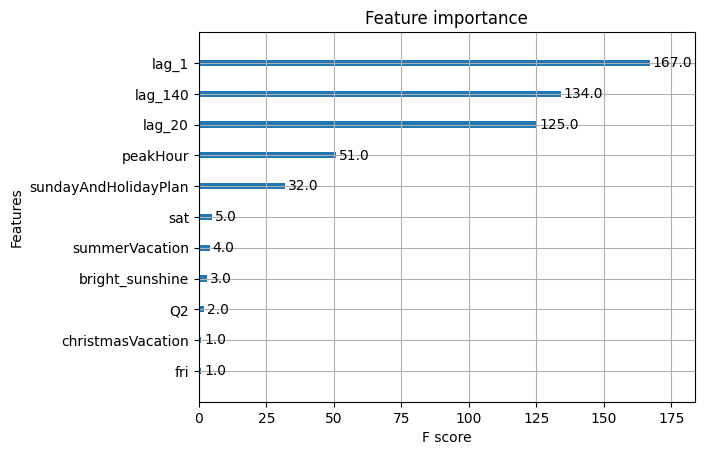

In [10]:
# expanding window forecast (reestimation)
horizon = 40
lags = [1, 20, 140]
diff = 1

model = xgb.XGBRegressor(n_estimators=35, max_depth=4, eta=0.05, seed=42)
scalar = StandardScaler()
exog_scalar = StandardScaler()

model, y_train_pred, y_val_pred = utils.expandingWindowForecastSklearn(
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model,
    horizon=horizon, differentiation=diff, lags=lags, 
    scalar=scalar, exog_scalar=exog_scalar)

print('train MAE%:', utils.MAE(y=y_train, yhat=y_train_pred))
print('train MAPE:', utils.MAPE(y=y_train, yhat=y_train_pred))
print('train RMSE%:', utils.RMSE(y=y_train, yhat=y_train_pred))

print('val MAE%:', utils.MAE(y=y_val, yhat=y_val_pred))
print('val MAPE:', utils.MAPE(y=y_val, yhat=y_val_pred))
print('val RMSE%:', utils.RMSE(y=y_val, yhat=y_val_pred))

plt.plot(X_val.index, val60_line['passengersBoarding'], color='red', label='gt')
plt.plot(X_val.index, y_val_pred, color='blue', alpha=0.5, label='pred')
plt.xticks(range(y_val.index[0], y_val.index[-1] + 1, horizon*3), val60_line['datetime'].values[::horizon*3], rotation=90)
plt.title('passenger val, recursive expanding window')
plt.legend()
plt.show()

xgb.plot_importance(model)

RangeIndex(start=7400, stop=14680, step=1)
RangeIndex(start=7440, stop=14720, step=1)
RangeIndex(start=7480, stop=14760, step=1)
RangeIndex(start=7520, stop=14800, step=1)
RangeIndex(start=7560, stop=14840, step=1)
RangeIndex(start=7600, stop=14880, step=1)
RangeIndex(start=7640, stop=14920, step=1)


The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.


RangeIndex(start=7680, stop=14960, step=1)
RangeIndex(start=7720, stop=15000, step=1)
RangeIndex(start=7760, stop=15040, step=1)
RangeIndex(start=7800, stop=15080, step=1)
RangeIndex(start=7840, stop=15120, step=1)
RangeIndex(start=7880, stop=15160, step=1)
RangeIndex(start=7920, stop=15200, step=1)
RangeIndex(start=7960, stop=15240, step=1)
RangeIndex(start=8000, stop=15280, step=1)
RangeIndex(start=8040, stop=15320, step=1)
RangeIndex(start=8080, stop=15360, step=1)
RangeIndex(start=8120, stop=15400, step=1)
RangeIndex(start=8160, stop=15440, step=1)
RangeIndex(start=8200, stop=15480, step=1)
RangeIndex(start=8240, stop=15520, step=1)
RangeIndex(start=8280, stop=15560, step=1)
RangeIndex(start=8320, stop=15600, step=1)
RangeIndex(start=8360, stop=15640, step=1)
RangeIndex(start=8400, stop=15680, step=1)
RangeIndex(start=8440, stop=15720, step=1)
RangeIndex(start=8480, stop=15760, step=1)
RangeIndex(start=8520, stop=15800, step=1)
RangeIndex(start=8560, stop=15840, step=1)
RangeIndex(

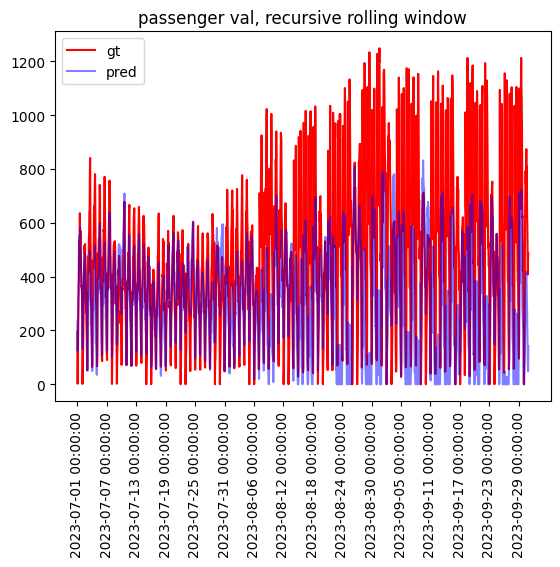

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

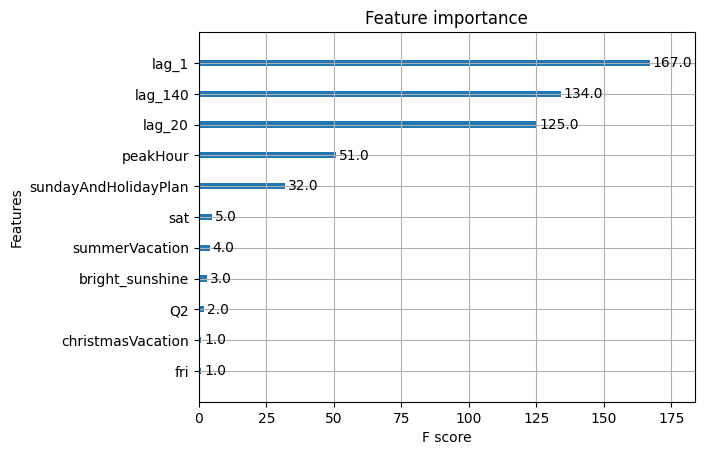

In [11]:

horizon = 40
lags = [1, 20, 140]
diff = 1
model = xgb.XGBRegressor(n_estimators=35, max_depth=4, eta=0.05, seed=42)
scalar = StandardScaler()
exog_scalar = StandardScaler()

model, y_train_pred, y_val_pred = utils.slidingWindowForecastSklearn(
    X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, model=model, 
    differentiation=diff, horizon=horizon, window_size=20*7*52, lags=lags, 
    scalar=scalar, exog_scalar=exog_scalar)

print('train MAE%:', utils.MAE(y=y_train, yhat=y_train_pred))
print('train MAPE:', utils.MAPE(y=y_train, yhat=y_train_pred))
print('train RMSE%:', utils.RMSE(y=y_train, yhat=y_train_pred))

print('val MAE%:', utils.MAE(y=y_val, yhat=y_val_pred))
print('val MAPE:', utils.MAPE(y=y_val, yhat=y_val_pred))
print('val RMSE%:', utils.RMSE(y=y_val, yhat=y_val_pred))

plt.plot(X_val.index, val60_line['passengersBoarding'], color='red', label='gt')
plt.plot(X_val.index, y_val_pred, color='blue', alpha=0.5, label='pred')
plt.xticks(range(y_val.index[0], y_val.index[-1] + 1, horizon*3), val60_line['datetime'].values[::horizon*3], rotation=90)
plt.title('passenger val, recursive rolling window')
plt.legend()
plt.show()

xgb.plot_importance(model)